# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 


## 1. Обзор данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# чтение файла с данными и сохранение в data
data = pd.read_csv('real_estate_data.csv' ,sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Согласно документации к данным:

airports_nearest — расстояние до ближайшего аэропорта в метрах (м);

balcony — число балконов;

ceiling_height — высота потолков (м);

cityCenters_nearest — расстояние до центра города (м);

days_exposition — сколько дней было размещено объявление (от публикации до снятия);

first_day_exposition — дата публикации;

floor — этаж;

floors_total — всего этажей в доме;

is_apartment — апартаменты (булев тип);

kitchen_area — площадь кухни в квадратных метрах (м²);

last_price — цена на момент снятия с публикации;

living_area — жилая площадь в квадратных метрах (м²);

locality_name — название населённого пункта;

open_plan — свободная планировка (булев тип);

parks_around3000 — число парков в радиусе 3 км;

parks_nearest — расстояние до ближайшего парка (м);

ponds_around3000 — число водоёмов в радиусе 3 км;

ponds_nearest — расстояние до ближайшего водоёма (м);

rooms — число комнат;

studio — квартира-студия (булев тип);

total_area — площадь квартиры в квадратных метрах (м²);

total_images — число фотографий квартиры в объявлении.

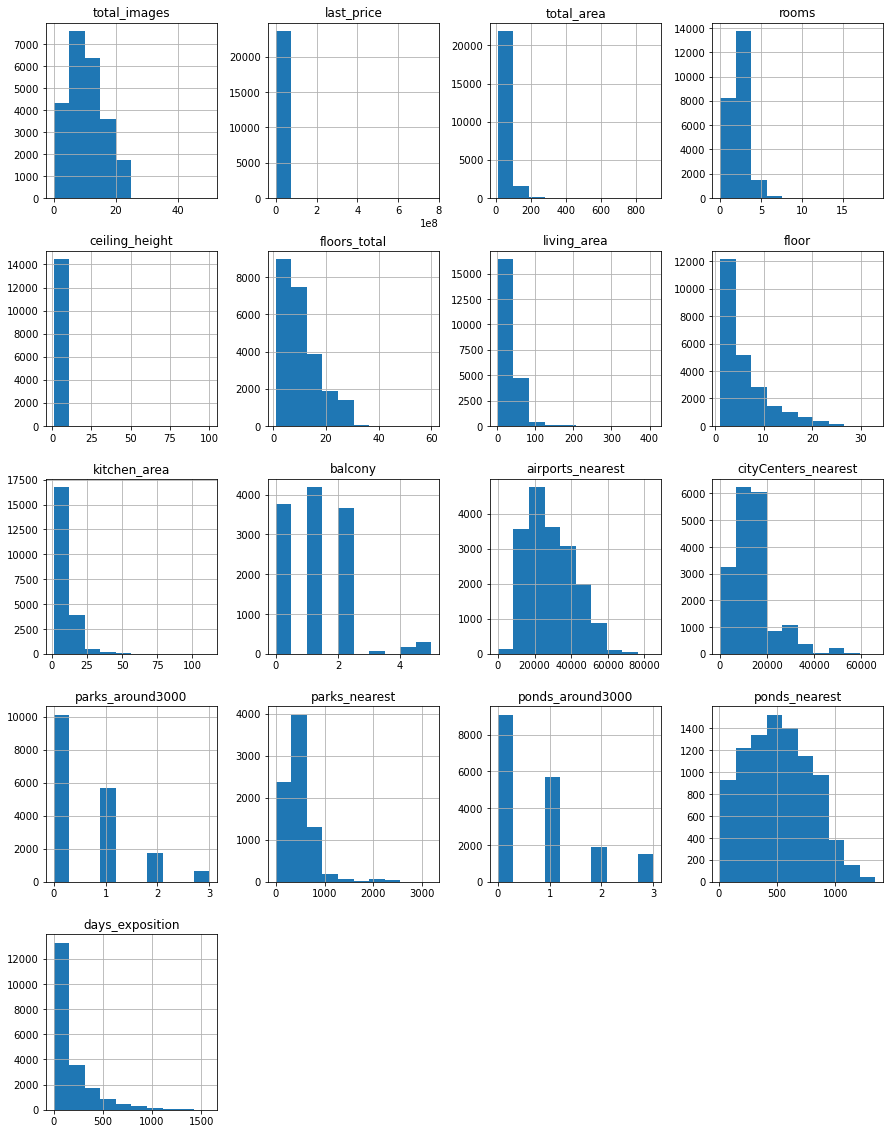

In [3]:
data.hist(figsize=(15, 20))
plt.show()

Вывод: всего у нас 23699 записи. Для целого ряда столбцов есть пропущенные значения и некорректный тип данных. По ряду признаков есть аномальные значения.
Стоит отметить недочеты:
1. first_day_exposition - object - должен быть тип datetime
2. ceiling_height - нулевые значения
3. floors_total - должен быть тип int, т.к. количество этажей - целое значение + нулевые значения
4. is_apartment - должен быть тип bool + нулевые значения
5. living_area - нулевые значения
6. kitchen_area - нулевые значения
7. balcony - нулевые значения
8. locality_name  - нулевые значения
9. airports_nearest - нулевые значения
10. cityCenters_nearest - нулевые значения
11. parks_around3000 - тип должен быть int + нулевые значения
12. parks_nearest  - нулевые значения
13. ponds_around3000 - тип должен быть int + нулевые значения
14. ponds_nearest - нулевые значения
15. days_exposition - тип должен быть int + нулевые значения 


## 2. Предобработка данных

### Стиль заголовков

In [4]:
# перечень названий столбцов таблицы data
print(data.columns)

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')


In [5]:
# переименование столбцов
data = data.rename(columns={
    'cityCenters_nearest': 'city_centers_nearest', 'parks_around3000': 'parks_around_3000',
    'ponds_around3000': 'ponds_around_3000'})


data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

### Заполнение пропусков

In [6]:
#определяем пропущенные значения
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

#### Заполняем пропущенные значения там, где это возможно. Изучим высоту потолков в квартирах

Значения max (100) и min (1) - ошибочны. Поэтому для расчета пропусков возьмем медиану значений. Она ровна 2.65, что является нормальным значение для квартир в новостройках (примерно 2.5-2.7 м). Высота потолков в элитном жилье может оставлять больше 3 метров, но рынок элитного жилья не так широко распространён


In [7]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [8]:
ceiling_height_median=data['ceiling_height'].median()
data['ceiling_height']=data['ceiling_height'].fillna(ceiling_height_median)
data['ceiling_height'].describe()

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

#### Число этажей в доме

Пропуски в 'floors_total' равны 0.4%. Данное число мало, и заполнять пропуски нет смысла. Пропуски могут быть связаны с отсутствием значения из-за невнимательности или дом является одноэтажным (таунхаус)

In [9]:
print(round(data['floors_total'].isna().value_counts()[1]/ len(data),3)*100)

0.4


#### Жилая площадь

Предположим, что размер жилой площади зависит от площади квартиры и количества комнат. Выясним, какую часть общей площади квартиры занимает жилая площадь для однокомнатной, двухкомнатной и т д квартир.
Заполним пропуски в этом столбце медианным значением по каждому типу (в данном случае количеству жилых комнат) из столбца rooms

In [10]:
data['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
15       1
19       1
16       1
12       1
Name: rooms, dtype: int64

In [11]:
for area in data['rooms'].unique():
    data.loc[(data['rooms'] == area) & (data['living_area'].isna()), 'living_area'] = data.loc[(data['rooms'] == area), 'living_area'].median()

data['living_area'].isnull().sum() 

0

#### Апартаменты

Для удобства поменяем тип данных в is_apartment на boolean

In [12]:
data['is_apartment'] = data['is_apartment'].astype('bool')  

data['is_apartment'].value_counts()

True     20974
False     2725
Name: is_apartment, dtype: int64

#### Площадь кухни

Площадь кухни коррелирует с общей площадью квартиры, но для заполнения в зависимости от нее придется разбивать пощадь квартир на категории.
Заменим пропущенные значения площади кухни в квартирах-студиях на нули

In [13]:
data['total_area'].corr(data['kitchen_area'])

0.6091211711198318

In [14]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

In [15]:
data.loc[data['studio'] == True, 'kitchen_area'] = 0

In [16]:
#Рассмотрим отношение размера кухни к общей площади кухни по категориям
median_40 = data.loc[(data['total_area'] <= 40), 'kitchen_area']/data.loc[(data['total_area'] <= 40), 'total_area'].median()
median_52 = data.loc[(data['total_area'] > 40) & (data['total_area'] <= 52), 'kitchen_area']/data.loc[(data['total_area'] > 40) & (data['total_area'] <= 52), 'total_area'].median()
median_70 = data.loc[(data['total_area'] > 52) & (data['total_area'] <= 70), 'kitchen_area']/data.loc[(data['total_area'] <= 70) & (data['total_area'] > 52), 'total_area'].median()
median_150 = data.loc[(data['total_area'] > 70) & (data['total_area'] <= 150), 'kitchen_area']/data.loc[(data['total_area'] > 70) & (data['total_area'] <= 150), 'total_area'].median()
median_151= data.loc[(data['total_area'] > 150), 'kitchen_area']/data.loc[(data['total_area'] > 150), 'total_area'].median()

In [17]:
data.loc[(data['kitchen_area'].isnull() == True) & (data['total_area'] <= 40), 'kitchen_area'] = data.loc[(data['kitchen_area'].isnull() == True) & (data['total_area'] <= 40), 'total_area'] * median_40
data.loc[(data['kitchen_area'].isnull() == True) & (data['total_area'] >40) & (data['total_area'] <= 52), 'kitchen_area'] = data.loc[(data['kitchen_area'].isnull() == True) & (data['total_area'] >40) & (data['total_area'] <= 52),'total_area'] * median_52
data.loc[(data['kitchen_area'].isnull() == True) & (data['total_area'] >52) & (data['total_area'] <= 70), 'kitchen_area'] = data.loc[(data['kitchen_area'].isnull() == True) & (data['total_area'] >52) & (data['total_area'] <= 70),'total_area'] * median_70
data.loc[(data['kitchen_area'].isnull() == True) & (data['total_area'] >70) & (data['total_area'] <= 150), 'kitchen_area'] = data.loc[(data['kitchen_area'].isnull() == True) & (data['total_area'] >70) & (data['total_area'] <= 150),'total_area'] * median_150
data.loc[(data['kitchen_area'].isnull() == True) & (data['total_area'] >150), 'kitchen_area'] = data.loc[(data['kitchen_area'].isnull() == True) & (data['total_area'] > 150), 'total_area'] * median_151


#### Число балконов

Заменим пропуски в balcony на 0 и изменим тип данных на int8

In [18]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype('int8')

In [19]:
for dtype in ['int','int8']:
    selected_dtype = data.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))
print('Экономия', round(((0.14-0.01)*100)/0.14), '%')

Average memory usage for int columns: 0.14 MB
Average memory usage for int8 columns: 0.01 MB
Экономия 93 %


#### Название населенного пункта

Поменяем тип данных в locality_name на string

In [20]:
data['locality_name'] = data['locality_name'].astype('str')  

#### Cколько дней было размещено объявление (от публикации до снятия)

Для удобства поменяем тип данных в days_exposition на int. Объявления которые равны 0 будем считать, что еще не сняты с публикации.

In [21]:
data['days_exposition'] = data['days_exposition'].fillna(0).astype('int') 
data['days_exposition'].value_counts()

0       3181
45       880
60       538
7        234
30       208
        ... 
1021       1
1362       1
1105       1
795        1
971        1
Name: days_exposition, Length: 1142, dtype: int64

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21570 non-null  float64       
 13  balcony         

Пропуски расстояния до центра города не получится чем-либо заменить, так же, как и название населенного пункта. 
Пропуски в данных ponds_nearest, ponds_around3000 могут быть связаны с тем что в близи нет водоемов так же, как и parks_nearest, parks_around3000 нет рядом парков. Все пропущенные значения в колонках, связанных с расстоянием (airports_nearest, citycenters_nearest) оставляем в первоначальном виде.  Иначе искать зависимость цены от расстояния до центра будет некорректно


#### Проверим названия населённых пунктов на уникальность.

In [40]:
data['locality_name']=data['locality_name'].str.lower()

In [41]:
data['locality_name'] = data['locality_name'].str.replace('ё','е')

In [42]:
data['locality_name'].nunique()

328

Заменим на короткие версии названий Кудрово и Мурино, поселок рябово

In [43]:
data['locality_name']=data['locality_name'].replace('деревня кудрово','кудрово')
data['locality_name']=data['locality_name'].replace('поселок городского типа рябово','поселок рябово')
data['locality_name']=data['locality_name'].replace('поселок мурино','мурино')
data['locality_name'].unique()

array(['санкт-петербург', 'поселок шушары', 'городской поселок янино-1',
       'поселок парголово', 'мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'кудрово', 'коммунар', 'колпино',
       'поселок городского типа красный бор', 'гатчина',
       'деревня федоровское', 'выборг', 'кронштадт', 'кировск',
       'деревня новое девяткино', 'поселок металлострой',
       'поселок городского типа лебяжье',
       'поселок городского типа сиверский', 'поселок молодцово',
       'поселок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'поселок аннино',
       'поселок городского типа ефимовский', 'поселок плодовое',
       'деревня заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное село', 'поселок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', 'поселок новый свет', 'сланцы',
   

#### Устранение редких и выбивающихся значении. 

In [45]:
data['ceiling_height']=data['ceiling_height'].replace(32,3.2)
data['ceiling_height']=data['ceiling_height'].replace(25,2.5)
data['ceiling_height']=data['ceiling_height'].replace(26,2.6)
data['ceiling_height']=data['ceiling_height'].replace(27,2.7)
data['ceiling_height']=data['ceiling_height'].replace(25,2.5)
data['ceiling_height']=data['ceiling_height'].replace(24,2.4)
data['ceiling_height']=data['ceiling_height'].replace(22.6,2.26)
data = data[(data['ceiling_height'] != 1) & (data['ceiling_height'] != 100)& (data['ceiling_height'] != 20) & (data['ceiling_height'] != 10.3)]
data['ceiling_height'].unique()



array([ 2.7 ,  2.65,  3.03,  2.5 ,  2.67,  2.56,  3.05,  2.75,  2.6 ,
        2.9 ,  2.8 ,  2.55,  3.  ,  3.2 ,  2.61,  3.25,  3.45,  2.77,
        2.85,  2.64,  2.57,  4.15,  3.5 ,  3.3 ,  2.71,  4.  ,  2.47,
        2.73,  2.84,  3.1 ,  2.34,  3.4 ,  3.06,  2.72,  2.54,  2.51,
        2.78,  2.76,  2.58,  3.7 ,  2.52,  5.2 ,  2.87,  2.66,  2.59,
        2.  ,  2.45,  3.6 ,  2.92,  3.11,  3.13,  3.8 ,  3.15,  3.55,
        3.16,  3.62,  3.12,  2.53,  2.74,  2.96,  2.46,  5.3 ,  5.  ,
        2.79,  2.95,  4.06,  2.94,  3.82,  3.54,  3.53,  2.83,  4.7 ,
        2.4 ,  3.38,  3.01,  5.6 ,  3.65,  3.9 ,  3.18,  3.35,  2.3 ,
        3.57,  2.48,  2.62,  2.82,  3.98,  2.63,  3.83,  3.52,  3.95,
        3.75,  2.88,  3.67,  3.87,  3.66,  3.85,  3.86,  4.19,  3.24,
        4.8 ,  4.5 ,  4.2 ,  3.36,  3.08,  3.68,  3.07,  3.37,  3.09,
        8.  ,  3.26,  3.34,  2.81,  3.44,  2.97,  3.14,  4.37,  2.68,
        3.22,  3.27,  4.1 ,  2.93,  3.46,  3.47,  3.33,  3.63,  3.32,
        1.2 ,  8.3 ,

In [46]:
#В лениградской области нет дома 52, 60 этажа, удаляем 
data = data[(data['floors_total'] !=52) & (data['floors_total'] != 60)]
data['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34.,  1., 29., 33., 37.])

Из особенностей данных стоит отметить не стандартные высоты потолков (убрали все высоты от 10 м до 20 и обработали разные аномалии), так же были исключены дома этажностью 52 и 60 этажей, т.к. в Ленинградской области самый высокий дом равен 37 этажам

### Добавим в таблицу новые столбцы

#### Цена одного квадратного метра

In [47]:
data['price_square_meter'] = data['last_price'] / data['total_area']
#для удобства приведем к типу int
data['price_square_meter'] = data['price_square_meter'].astype('int')

#### День недели публикации объявления ; месяц публикации объявления; год публикации объявления;

In [48]:
#столбец дня недели
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday

#столбец месяца
data['month_exposition'] = data['first_day_exposition'].dt.month

#столбец года
data['year_exposition'] = data['first_day_exposition'].dt.year

####  Тип этажа квартиры (значения — «первый», «последний», «другой»)

In [49]:
#напишем функцию категоризации по этажам, используя метод apply применимо к каждой строке датафрейма через axis = 1
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    return 'другой'
data['floor_category'] = data.apply(floor_category, axis = 1)
data['floor_category'].value_counts()

другой       17441
последний     3335
первый        2917
Name: floor_category, dtype: int64

#### Расстояние до центра города в километрах (переведем из м в км и округлим до целых значений).

In [50]:
data['city_centers_nearest_km']= round(data['city_centers_nearest']/1000)

In [51]:
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category,city_centers_nearest_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.0,8,True,...,482.0,2.0,755.0,0,120370,3,3,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.6,1,True,...,NaN,0.0,NaN,81,82920,1,12,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.3,4,True,...,90.0,2.0,574.0,558,92785,3,8,2015,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,45.0,9,True,...,84.0,3.0,234.0,424,408176,4,7,2015,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.0,13,True,...,112.0,1.0,48.0,121,100000,1,6,2018,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.3,3,True,...,796.0,3.0,381.0,0,72490,1,3,2017,другой,4.0
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5.0,38.0,4,True,...,NaN,NaN,NaN,45,52542,0,1,2018,другой,NaN
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3.0,29.7,1,True,...,NaN,NaN,NaN,0,44091,6,2,2018,первый,NaN
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17.0,30.5,12,True,...,173.0,3.0,196.0,602,149511,1,3,2017,другой,10.0


### Проведем исследовательский анализ данных

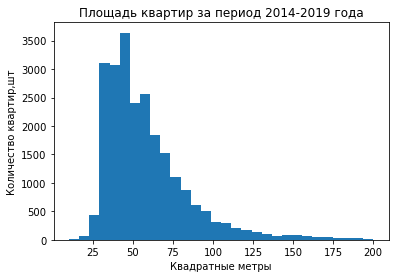

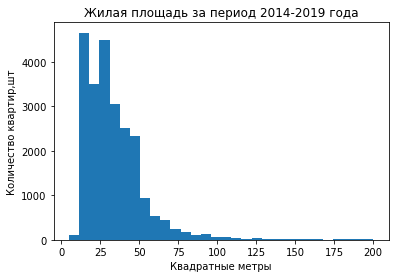

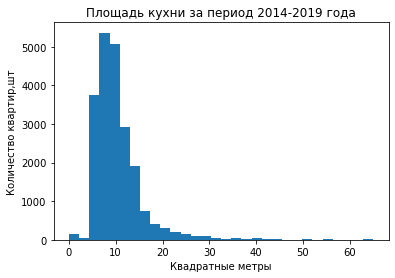

In [52]:
#общая площадь
plt.hist(data['total_area'], bins=30, range=(10,200))
plt.title('Площадь квартир за период 2014-2019 года')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир,шт')
plt.show()

#жилая площадь
plt.hist(data['living_area'], bins=30, range=(5,200))
plt.title('Жилая площадь за период 2014-2019 года')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир,шт')
plt.show()
#площадь кухни;
plt.hist(data['kitchen_area'], bins=30, range=(0,65))
plt.title('Площадь кухни за период 2014-2019 года')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир,шт')
plt.show()

Распределение данных нормальное, есть выбросы но они не сильно влияют на данные

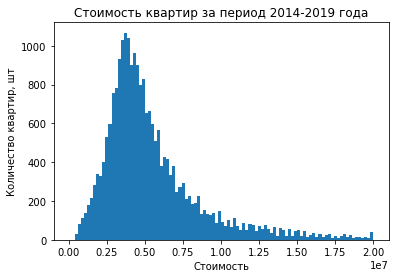

In [53]:
#изучим цену
plt.hist(data['last_price'], bins=100, range=(0,20000000))
plt.title('Стоимость квартир за период 2014-2019 года')
plt.xlabel('Стоимость')
plt.ylabel('Количество квартир, шт')
plt.show()
#с данными все впорядке но значения выводятся в экспоненциальной записи чисел

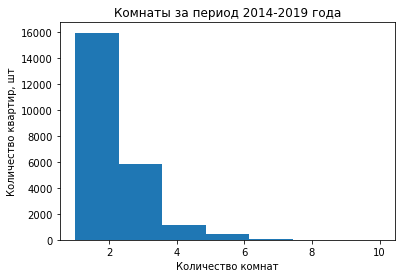

In [54]:
#количество комнат;
plt.hist(data['rooms'], bins=7, range=(1,10))
plt.title('Комнаты за период 2014-2019 года')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир, шт')
plt.show()

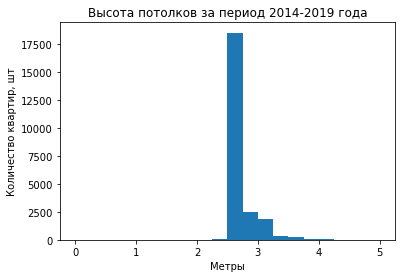

In [55]:
#высота потолков;
plt.hist(data['ceiling_height'], bins=20, range = (0,5))
plt.title('Высота потолков за период 2014-2019 года')
plt.xlabel('Метры')
plt.ylabel('Количество квартир, шт')
plt.show()

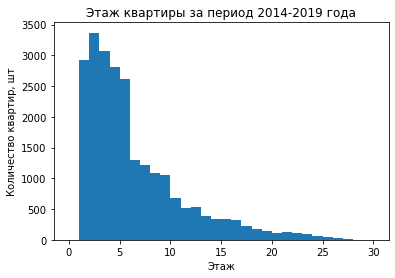

In [56]:
#этаж квартиры;
plt.hist(data['floor'], bins=30, range = (0,30))
plt.title('Этаж квартиры за период 2014-2019 года')
plt.xlabel('Этаж')
plt.ylabel('Количество квартир, шт')
plt.show()

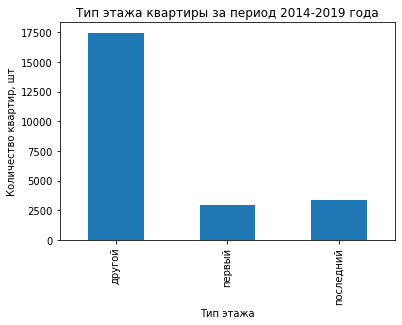

In [57]:
#тип этажа квартиры («первый», «последний», «другой»);
data_floor=(data.groupby('floor_category')['floor'].count())
data_floor.plot.bar( x='floor_category', y='floor')
plt.title('Тип этажа квартиры за период 2014-2019 года')
plt.xlabel('Тип этажа')
plt.ylabel('Количество квартир, шт')
plt.show()

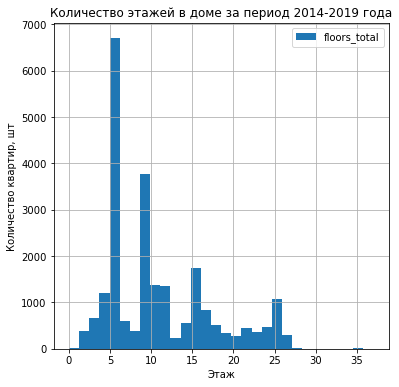

In [58]:
#общее количество этажей в доме
data.plot(y = 'floors_total', kind = 'hist', bins = 30,range = (0,37), grid=True, figsize = (6,6))
plt.title('Количество этажей в доме за период 2014-2019 года')
plt.xlabel('Этаж')
plt.ylabel('Количество квартир, шт')
plt.show()

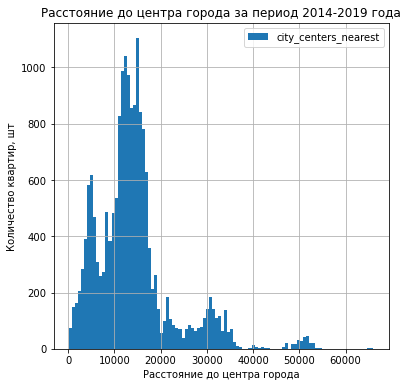

In [59]:
#расстояние до центра города в метрах;
data.plot(y = 'city_centers_nearest', kind = 'hist', bins = 100, grid=True, figsize = (6,6))
plt.title('Расстояние до центра города за период 2014-2019 года')
plt.xlabel('Расстояние до центра города')
plt.ylabel('Количество квартир, шт')
plt.show()

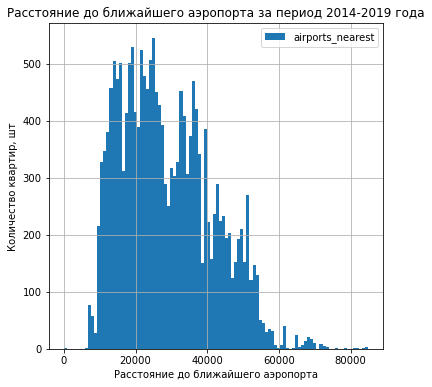

In [60]:
#расстояние до ближайшего аэропорта;;
data.plot(y = 'airports_nearest', kind = 'hist', bins = 100, grid=True, figsize = (6,6))
plt.title('Расстояние до ближайшего аэропорта за период 2014-2019 года')
plt.xlabel('Расстояние до ближайшего аэропорта')
plt.ylabel('Количество квартир, шт')
plt.show()

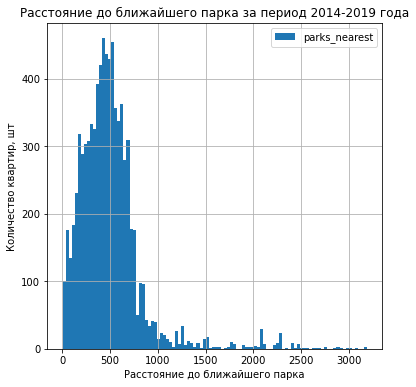

In [61]:
#расстояние до ближайшего парка;
data.plot(y = 'parks_nearest', kind = 'hist', bins = 100, grid=True, figsize = (6,6))
data['parks_nearest'].describe()
plt.title('Расстояние до ближайшего парка за период 2014-2019 года')
plt.xlabel('Расстояние до ближайшего парка')
plt.ylabel('Количество квартир, шт')
plt.show()

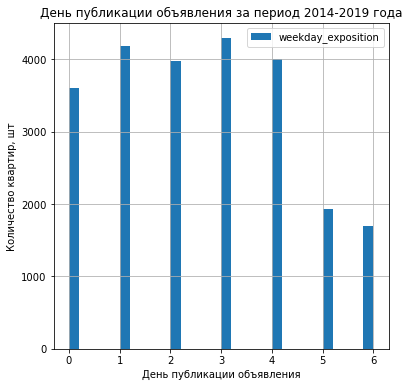

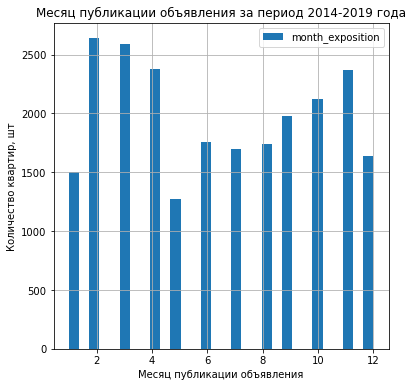

In [62]:
#день публикации объявления.
data.plot(y = 'weekday_exposition', kind = 'hist', bins = 30, grid=True, figsize = (6,6))
plt.title('День публикации объявления за период 2014-2019 года')
plt.xlabel('День публикации объявления')
plt.ylabel('Количество квартир, шт')
plt.show()
#месяц публикации объявления.
data.plot(y = 'month_exposition', kind = 'hist', bins = 30, grid=True, figsize = (6,6))
plt.title('Месяц публикации объявления за период 2014-2019 года')
plt.xlabel('Месяц публикации объявления')
plt.ylabel('Количество квартир, шт')
plt.show()


1. Большинство квартир - менее 100 квадратных метров, больше площадь практически не встречается. В подборке есть несколько очень больших и странных вариантов с площадью более 200 квадратных метров. Самый популярный вариант квартир 40-45  квадратных метров.
Жилая площадь до 25 квадратных метров, кухни от 5 до 10  квадратных метров. После 80 метров встречаются единичные случаи. Два пика графика вызваны, вероятно, тем, что это жилые площади для 1-комнатной, затем для 2-комнатной и после этого для 3-комнатной квартиры.
Больше 20 метров кухни практически не встречаются. Больше 30 - единичные случаи.
2. В основном стоимость квартир - порядка 5 миллионов. Больше 20 миллионов вариантов мало и они выглядят очень странно и некоторые - на порядок дороже.
3. В основном квартиры состоят из 1, 2 и 3 комнат. Есть небольшая доля 4-комнатных квартир. Варианты, где больше 7 комнат выглядят странно и подозрительно. Хотя в Санкт-Петербурге есть коммуналки, их очень редко выставляют на продажу целиком как квартиру. Не стоит удалять подобные варианты из данных, хоть для других регионов это смотрелось бы неправильно или считалось как частный дом.
4. Большинство вариантов имеют высоту потолков от 2,5 до 3 метров. Больше 4 метров высота потолков выглядит подозрительно.
5. Среди этажей квартир лидирует 3. По типу этажности популярен "другой". Распестрённые варианты среди общего количества этажей в доме 5 , 9 . Предполагаю, что это дома хрущёвской постройки и панельные дома 9 этажей 80-х годов.
6. Расстояние до ближайшего парка от 300 до 500 метров. Расстояние до ближайшего аэропорта от 10 до 30 км. Расстояние до центра города от 10 до 18 км 
7. Популярными днями для публикации объявления являются вторник и четверг. Популярными месяцами публикации объявления являются февраль, март

In [63]:
#Рассмотрим, как быстро продавались квартиры (столбец days_exposition)
# Найдем медиану и среднее
data['days_exposition'].describe()

count    23693.000000
mean       156.632507
std        213.566296
min          0.000000
25%         22.000000
50%         74.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [64]:
data['days_exposition'].median()

74.0

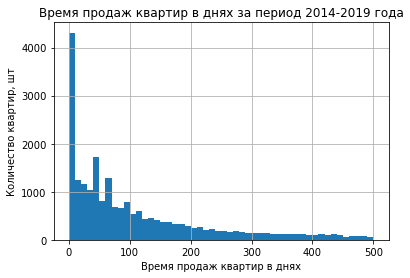

In [65]:
#Построим гистограмму по времени продажи квартиры
data['days_exposition'].hist(bins=50, range = (0, 500))
plt.title('Время продаж квартир в днях за период 2014-2019 года')
plt.xlabel('Время продаж квартир в днях')
plt.ylabel('Количество квартир, шт')
plt.show()

Медианное время продажи - 74 дней. Среднее время продажи - 156 день.
В основном квартиры продаются за срок в 80 дней. Есть большое число квартир, проданных всего за несколько дней после публикации. А также есть варианты, которые продавались несколько десятков месяцев.
Быстрой продажей можно назвать срок в 22 дня и меньше. Долгой продажей - 200 дней (7 месяцев) и дольше.

По правилам размещения объявлений в Яндекс Недвижимость, обьявление снимают через определенный срок автоматически: до 4,5 млн — 45 дней, от 4,5 до 10 млн — 60 дней, от 10 млн — 90 дней.Уберем эти значения

(1.0, 1000.0)

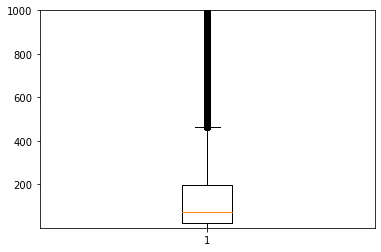

In [66]:
#диаграмма размаха
plt.boxplot(data['days_exposition'])
plt.ylim(1,1000)

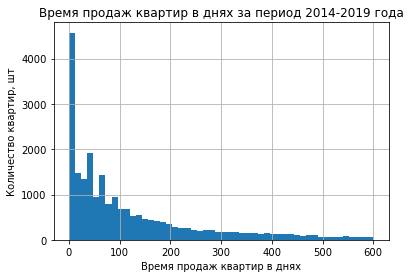

In [67]:
#Построим гистограмму по времени продажи квартиры
data['days_exposition'].hist(bins=50, range = (0, 600))
plt.title('Время продаж квартир в днях за период 2014-2019 года')
plt.xlabel('Время продаж квартир в днях')
plt.ylabel('Количество квартир, шт')
plt.show()

In [181]:
#среднее значение, медиана и межквартильный размах
data['days_exposition'].describe()

count    22072.000000
mean       164.049429
std        219.409316
min          0.000000
25%         19.000000
50%         83.000000
75%        214.000000
max       1580.000000
Name: days_exposition, dtype: float64

Вывод: ожидаемо, в очищенных данных с аномалиями в значениях меньших медианы получаем большие значения медианы и среднего значения - 74 и 83 соответственно, вместо 156 и 164. Аналогично, теперь нормальные значения располагаются от 1 до 600 дней вместо от 1 до 500 дней.

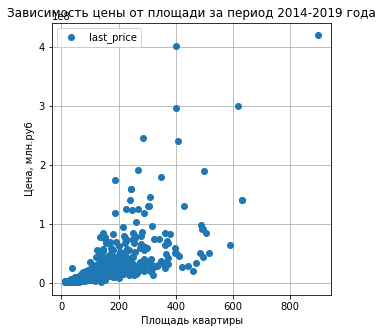

Корреляция цены и площади: 

            last_price  total_area
last_price    1.000000    0.738923
total_area    0.738923    1.000000 



In [68]:
# Зависимость цены от площади
(
    data.pivot_table(index='total_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.title('Зависимость цены от площади за период 2014-2019 года')
plt.xlabel('Площадь квартиры')
plt.ylabel('Цена, млн.руб')
plt.show()
print('Корреляция цены и площади:','\n')
print(data.pivot_table(index='floor', values=['total_area', 'last_price']).corr(),'\n')

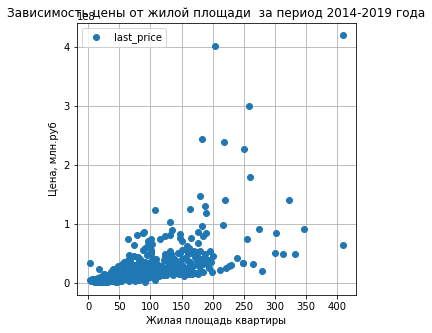

Корреляция цены и жилой площади: 

             last_price  living_area
last_price     1.000000     0.621799
living_area    0.621799     1.000000 



In [69]:
#зависимость цены от жилой площади 
(
    data.pivot_table(index='living_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.title('Зависимость цены от жилой площади  за период 2014-2019 года')
plt.xlabel('Жилая площадь квартиры')
plt.ylabel('Цена, млн.руб')
plt.show()
print('Корреляция цены и жилой площади:','\n')
print(data.pivot_table(index='floor', values=['living_area', 'last_price']).corr(),'\n')

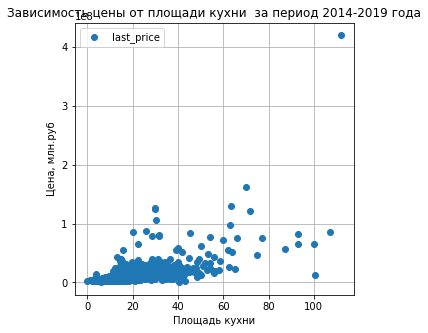

Корреляция цены и площади кухни: 

              kitchen_area  last_price
kitchen_area      1.000000    0.368378
last_price        0.368378    1.000000 



In [70]:
# Зависимость цены от площади кухни;
(
    data.pivot_table(index='kitchen_area', values='last_price')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.title('Зависимость цены от площади кухни  за период 2014-2019 года')
plt.xlabel('Площадь кухни')
plt.ylabel('Цена, млн.руб')
plt.show()
print('Корреляция цены и площади кухни:','\n')
print(data.pivot_table(index='floor', values=['kitchen_area', 'last_price']).corr(),'\n')

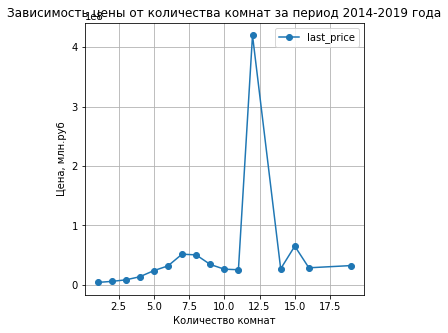

Корреляция цены и количества комнат: 

            last_price     rooms
last_price    1.000000  0.435052
rooms         0.435052  1.000000 



In [71]:
# Зависимость цены от количества комнат
(
    data.query('rooms> 0').pivot_table(index='rooms', values='last_price')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.title('Зависимость цены от количества комнат за период 2014-2019 года')
plt.xlabel('Количество комнат')
plt.ylabel('Цена, млн.руб')
plt.show()
print('Корреляция цены и количества комнат:','\n')
print(data.query('rooms > 0').pivot_table(index='floor', values=['rooms', 'last_price']).corr(),'\n')

Чем больше площадь, тем выше стоимость. Корреляция этих параметров крайне высокая. Число комнат влияет на цену (больше комнат - больше цена), однако зависимость ниже, чем у площади. 

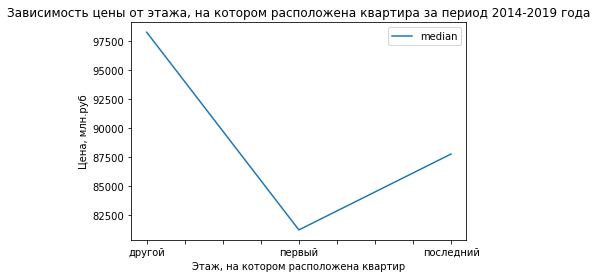

,mean,count,median
floor_category,,,
другой,103488.327504,17441,98290
первый,81983.111759,2917,81223
последний,93258.366717,3335,87777


In [72]:
#этажа, на котором расположена квартира (первый, последний, другой)
pivot_table_floor_category = data.pivot_table(index = 'floor_category', values = 'price_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_floor_category.columns = ['mean', 'count', 'median']
pivot_table_floor_category.plot(y = 'median')
plt.title('Зависимость цены от этажа, на котором расположена квартира за период 2014-2019 года')
plt.xlabel('Этаж, на котором расположена квартир')
plt.ylabel('Цена, млн.руб')
plt.show()
pivot_table_floor_category

Вывод:Согласно медиане - как правило квартиры на первом этаже дешевле квартир на последнем этаже - в среднем на 10%

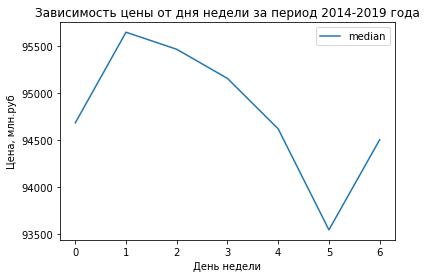

,mean,count,median
weekday_exposition,,,
1,99740.692492,4182,95643.0
2,99488.368328,3972,95461.5
3,100166.343037,4294,95152.0
0,99437.991138,3611,94680.0
4,99011.697000,4000,94616.0
6,97707.917010,1699,94501.0
5,99008.027390,1935,93543.0


In [73]:
#даты размещения (день недели)
pivot_table_weekday_exposition = data.pivot_table(index = 'weekday_exposition', values = 'price_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']
pivot_table_weekday_exposition.plot(y = 'median')
plt.title('Зависимость цены от дня недели за период 2014-2019 года')
plt.xlabel('День недели')
plt.ylabel('Цена, млн.руб')
plt.show()
pivot_table_weekday_exposition.sort_values('median', ascending = False)

Вывод: видим, что чем ближе ко вторнику выставлены объявления тем в среднем выше стоимость, но незначительно. По субботам стоимость самая низкая Стоит предположить, что стоимость выставленной на продажу недвижимости зависит от общей активности людей, так как именно в рабочие дни мы видим более высокие цены.

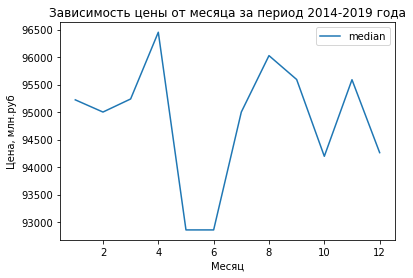

,mean,count,median
month_exposition,,,
4,101948.567045,2379,96451.0
8,100110.094037,1744,96026.0
9,100455.578575,1979,95592.0
11,99230.427246,2371,95588.0
3,98972.768844,2587,95238.0
1,99862.139333,1500,95222.0
2,98778.389920,2639,95000.0
7,99329.809917,1694,95000.0
12,99574.280926,1641,94262.0


In [74]:
#даты размещения (месяц)
pivot_table_month_exposition = data.pivot_table(index = 'month_exposition', values = 'price_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_month_exposition.columns = ['mean', 'count', 'median']
pivot_table_month_exposition.plot(y = 'median')
plt.title('Зависимость цены от месяца за период 2014-2019 года')
plt.xlabel('Месяц')
plt.ylabel('Цена, млн.руб')
plt.show()
pivot_table_month_exposition.sort_values('median', ascending = False)

Вывод: самая высокая стоимость метра в апреле и августе. Самая низкая стоимость в мае и июне. На рынке недвижимости, как и во многих других сферах присутствует сезонность - в начале лета мы видим наименьшее предложение как по количеству, так и по стоимости недвижимости. Наверное, это связано с отпусками.Высокая стомость в августе,может быть связана с приближением учебного года(многие переезжают в город и покупают квартиры студентам)

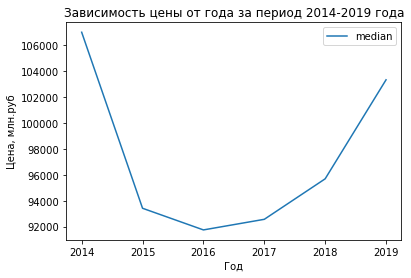

,mean,count,median
year_exposition,,,
2014,124830.000000,137,107000
2019,107135.494441,2878,103328
2018,97714.274222,8515,95687
2015,104613.756507,1191,93414
2017,97618.972890,8189,92561
2016,98321.900467,2783,91743


In [75]:
#даты размещения (год)
pivot_table_year_exposition = data.pivot_table(index = 'year_exposition', values = 'price_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_year_exposition.columns = ['mean', 'count', 'median']
pivot_table_year_exposition.plot(y = 'median')
plt.title('Зависимость цены от года за период 2014-2019 года')
plt.xlabel('Год')
plt.ylabel('Цена, млн.руб')
plt.show()
pivot_table_year_exposition.sort_values('median', ascending = False)

Квартиры очень сильно подешевели в 2016-2018 годах, что, вероятно, вызвано некоторым кризисом 2014-2015 годов. В 2019 году цены снова стали повышаться.Из распределения данных по годам видно, что рынок предложений был очень мал в 2016, 2017 году

In [76]:
#Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.
locality_pivot_table = data.pivot_table(index = 'locality_name', values = 'price_square_meter', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
locality_pivot_table

,count,mean
locality_name,,
санкт-петербург,15716,114821.574001
мурино,590,86087.055932
кудрово,472,95324.476695
поселок шушары,440,78676.904545
всеволожск,398,68654.007538
пушкин,369,103125.373984
колпино,338,75424.150888
поселок парголово,327,90175.489297
гатчина,307,68745.693811


In [77]:
#самая высокая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()]

,count,mean
locality_name,,
санкт-петербург,15716,114821.574001


In [78]:
#самая низкая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()]

,count,mean
locality_name,,
выборг,237,58141.489451


Вывод: самая высокая стоимость жилья из 10 населённых пунктов с самым большим количеством объявлений в Санкт-Петербурге, тогда как самая низкая стоимость в Выборге.

,price_square_meter
city_centers_nearest_km,
1.0,177004.963542
2.0,157848.564516
3.0,121386.991429
4.0,133282.422965
5.0,140509.339130
6.0,151011.750809
7.0,156176.445238
8.0,124875.176174
9.0,113130.595278


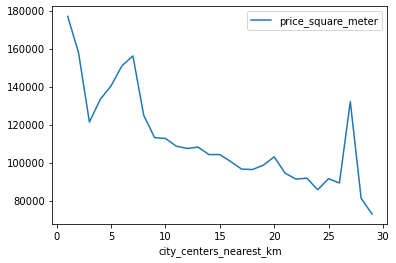

In [79]:
#Опишите, как стоимость объектов зависит от расстояния до центра города.
data['city_centers_nearest_km'] = data['city_centers_nearest_km'].fillna(0)
pivot_table_km = data.query('locality_name == "санкт-петербург" and city_centers_nearest_km !=0').pivot_table(index = 'city_centers_nearest_km', values = 'price_square_meter', aggfunc = 'mean')
pivot_table_km.plot()
pivot_table_km

Центральная зона - это 7 км и меньше. Дальше 7 км средняя цена на квартиры резко снижается.

### Общий вывод

1. Чаще всего квартиру продают за 75 дней. Если меньше 22 дней, то это быстро, если дольше 200 дней - это долго. Есть большое число квартир, проданных всего за несколько дней после публикации. Также есть варианты, которые продавались несколько десятков месяцев.
2. Самый популярный вариант квартир 40-45 квадратных метров. Жилая площадь до 25 квадратных метров, кухни от 5 до 10 квадратных метров. После 80 метров встречаются единичные случаи. Два пика графика вызваны, вероятно, тем, что это жилые площади для 1-комнатной, затем для 2-комнатной и после этого для 3-комнатной квартиры. Больше 20 метров кухни практически не встречаются. Больше 30 - единичные случаи.
В основном стоимость квартир - порядка 5 миллионов. Больше 20 миллионов вариантов мало и они выглядят очень странно и некоторые - на порядок дороже.
В основном квартиры состоят из 1, 2 и 3 комнат. Есть небольшая доля 4-комнатных квартир. Варианты, где больше 7 комнат выглядят странно и подозрительно. Хотя в Санкт-Петербурге есть коммуналки, их очень редко выставляют на продажу целиком как квартиру. Не стоит удалять подобные варианты из данных, хоть для других регионов это смотрелось бы неправильно или считалось как частный дом.
Первый этаж значительно дешевле остальных вариантов. Также стоимость квартиры на последнем этаже ниже, чем на остальных, кроме первого.
Распестрённые варианты среди общего количества этажей в доме 5 , 9 . Предполагаю, что это дома хрущёвской постройки и панельные дома 9 этажей 80-х годов.
3. Самая высокая стоимость метра в апреле и августе. Самая низкая стоимость в мае и июне. На рынке недвижимости, как и во многих других сферах присутствует сезонность - в начале лета мы видим наименьшее предложение как по количеству, так и по стоимости недвижимости. Наверное, это связано с отпусками.Высокая стомость в августе,может быть связана с приближением учебного года(многие переезжают в город и покупают квартиры студентам)
4. Дороже всего квадратный метр в Санкт-Петербурге 114821. Дешевле всего квадратный метр в Выборге - 58141
5. Также важно учитывать, что, рассматривая среднюю стоимость квартир в 2014-2019 годах, мы не делали сегментацию рынка, а лишь смотрели средние показатели по рынку в целом. Т.е. возможно, что цены на аналогичные квартиры в разных годах вели себя абсолютно по-разному.